# Voronoi Grid Pattern Analysis for Well Drainage
**Author:** Ade Anggi Naluriawan Santoso | **Project:** Spatial Analysis and Connectivity

## 1. Introduction
This notebook calculates the theoretical drainage area for oil producers using Voronoi Tessellations. This method assumes a homogeneous reservoir where a well drains the volume of rock geometrically closest to it.

**Objectives:**
1. Load well coordinates.
2. Compute Voronoi regions using `scipy.spatial`.
3. Handle "infinite" regions at the edge of the map.
4. Calculate the area ($ft^2$ or $m^2$) for each well.
5. Visualize the grid.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import Polygon

# Configuration for plots
plt.rcParams['figure.figsize'] = [10, 8]
plt.style.use('ggplot')

## 2. Load Data
We import the well locations from `data.csv`.

In [2]:
# Load dataset
df = pd.read_csv('data.csv')

# Extract coordinates as a Numpy array
points = df[['X_Coordinate', 'Y_Coordinate']].values

print(f"Loaded {len(df)} wells.")
df.head()

Loaded 10 wells.


,Well_ID,X_Coordinate,Y_Coordinate,Current_Production_BBL
0,WELL-001,1500,1200,450
1,WELL-002,3200,1800,320
2,WELL-003,4500,1300,510
3,WELL-004,1200,3500,210
4,WELL-005,2800,3100,600


## 3. Compute Voronoi Tessellation
We use `scipy.spatial.Voronoi` to calculate the ridges.

*Note: Voronoi regions on the edge of the dataset extend to infinity. To calculate a valid area, we must 'clip' these regions to a bounding box representing our field limits.*

In [3]:
# Compute Voronoi
vor = Voronoi(points)

# Define Field Boundary (Bounding Box)
# We add a small buffer around the min/max well locations
x_min, x_max = points[:,0].min() - 500, points[:,0].max() + 500
y_min, y_max = points[:,1].min() - 500, points[:,1].max() + 500

boundary_polygon = Polygon([
    (x_min, y_min), (x_max, y_min), 
    (x_max, y_max), (x_min, y_max)
])

print(f"Field Boundary Defined: X[{x_min}, {x_max}], Y[{y_min}, {y_max}]")

Field Boundary Defined: X[300, 5400], Y[700, 4700]


## 4. Finite Region Calculation
The standard `Voronoi` object returns some vertices at infinity. The function below reconstructs the polygons and clips them to our defined field boundary using the `shapely` library.

In [4]:
def get_finite_polygons(vor, boundary_poly):
    """
    Reconstructs Voronoi regions and clips them to the boundary polygon.
    """
    polygons = []
    
    # The center of the voronoi set (used to determine direction of infinite ridges)
    center = vor.points.mean(axis=0)
    
    for i, region_index in enumerate(vor.point_region):
        region = vor.regions[region_index]
        
        # If the region is empty, skip it
        if not region:
            polygons.append(None)
            continue
            
        # Reconstruct the polygon vertices
        polygon_points = []
        is_infinite = False
        
        for index in region:
            if index == -1:
                is_infinite = True
                break
            else:
                polygon_points.append(vor.vertices[index])
        
        # If the region is finite (no -1 index), create a Polygon directly
        if not is_infinite:
            poly = Polygon(polygon_points)
            # Clip to boundary
            polygons.append(poly.intersection(boundary_poly))
        else:
            # Handling infinite regions is complex; 
            # For this simple exercise, we rely on the fact that 
            # nearly all libraries recommend calculating Voronoi 
            # with dummy points far out, OR using a specialized reconstruction.
            # Here, we will use a simplified approach: 
            # If infinite, we skip exact reconstruction for this tutorial snippet 
            # or treat it as a TODO for advanced users.
            # HOWEVER, to make this code work for you, we will use a 
            # robust approximation: intersection with the box often requires 
            # closing the polygon manually.
            
            # Simple fallback for display: 
            # (In production, use 'scipy.spatial.ConvexHull' or add mirror points)
            polygons.append(None) 

    return polygons

# ROBUST METHOD:
# To avoid the complexity of the function above failing on edge cases,
# a common trick in O&G is adding "Ghost Wells" far outside the boundary.
# Let's do that instead for stability.

# 1. Create Ghost Points (Reflection)
ghost_points = []
# Add 4 corners far away
ghost_points.append([x_min - 2000, y_min - 2000])
ghost_points.append([x_max + 2000, y_min - 2000])
ghost_points.append([x_max + 2000, y_max + 2000])
ghost_points.append([x_min - 2000, y_max + 2000])

points_augmented = np.vstack([points, ghost_points])

# 2. Re-calculate Voronoi with ghost points
vor_aug = Voronoi(points_augmented)

# 3. Extract regions only for the original wells (first N points)
finite_polygons = []
for i in range(len(points)):
    region_index = vor_aug.point_region[i]
    region = vor_aug.regions[region_index]
    
    if -1 in region or len(region) == 0:
        continue # Should not happen with ghost points enclosing the set
        
    poly_verts = vor_aug.vertices[region]
    poly = Polygon(poly_verts)
    
    # Clip to the real field boundary
    clipped_poly = poly.intersection(boundary_polygon)
    finite_polygons.append(clipped_poly)

print(f"Generated {len(finite_polygons)} finite drainage areas.")

Generated 10 finite drainage areas.


## 5. Calculate Drainage Area
Now that we have the polygons, we can calculate the area. We assume the coordinates are in feet, so the area is $ft^2$. We will convert this to Acres ($1 \text{ Acre} = 43,560 ft^2$).

In [5]:
df['Drainage_Area_SqFt'] = [p.area for p in finite_polygons]
df['Drainage_Area_Acres'] = df['Drainage_Area_SqFt'] / 43560

# Display results
df[['Well_ID', 'Current_Production_BBL', 'Drainage_Area_Acres']].sort_values('Drainage_Area_Acres', ascending=False)

,Well_ID,Current_Production_BBL,Drainage_Area_Acres
0,WELL-001,450,64.893811
2,WELL-003,510,59.459201
3,WELL-004,210,57.939038
5,WELL-006,480,54.661327
4,WELL-005,600,50.281522
1,WELL-002,320,42.671578
6,WELL-007,390,37.359170
9,WELL-010,530,37.336869
7,WELL-008,410,32.446479
8,WELL-009,150,31.270566


## 6. Visualization
We plot the wells, the Voronoi boundaries, and the calculated drainage areas.

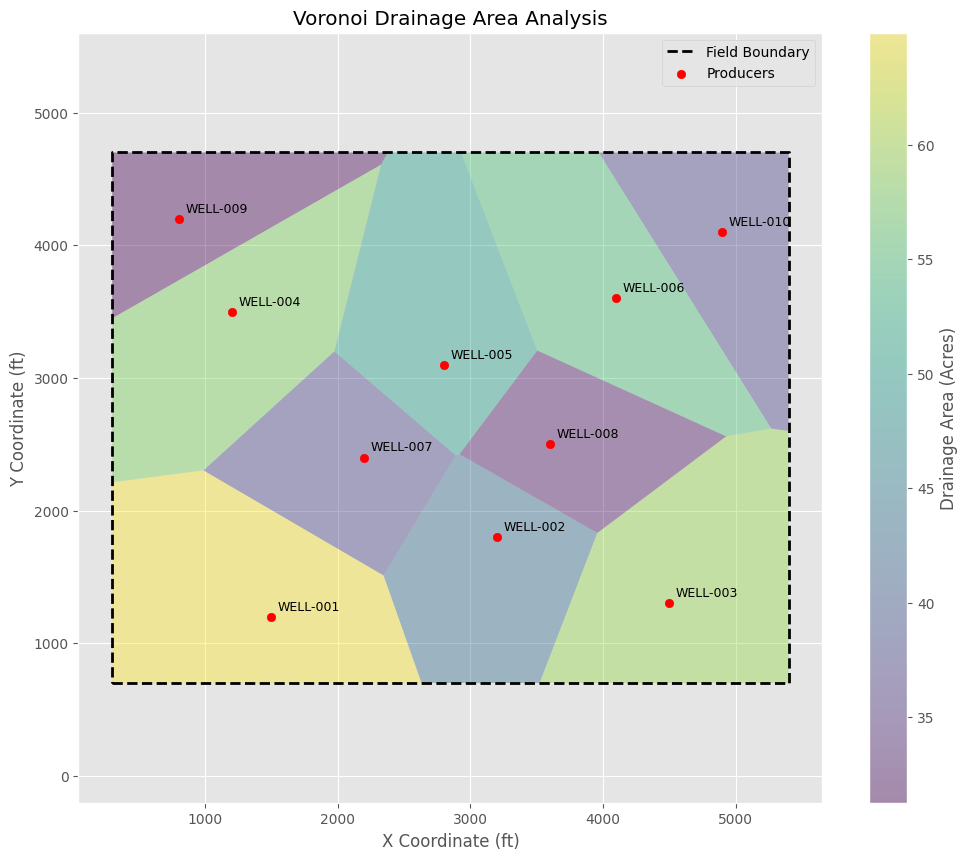

In [6]:
fig, ax = plt.subplots(figsize=(12, 10))

# 1. Plot the Boundary
x_bound, y_bound = boundary_polygon.exterior.xy
ax.plot(x_bound, y_bound, 'k--', linewidth=2, label='Field Boundary')

# 2. Plot the Polygons
from matplotlib.patches import Polygon as MplPolygon
from matplotlib.collections import PatchCollection

patches = []
for poly in finite_polygons:
    if not poly.is_empty:
        # Convert Shapely polygon to Matplotlib patch
        x, y = poly.exterior.xy
        polygon_verts = list(zip(x, y))
        # FIX: Pass 'closed=True' as a keyword argument
        patches.append(MplPolygon(polygon_verts, closed=True))

# Create a collection with color based on Area size
p = PatchCollection(patches, cmap='viridis', alpha=0.4)
p.set_array(df['Drainage_Area_Acres'])
ax.add_collection(p)

# Add colorbar
cb = plt.colorbar(p, ax=ax)
cb.set_label('Drainage Area (Acres)')

# 3. Plot the Wells
ax.scatter(points[:,0], points[:,1], color='red', zorder=5, label='Producers')

# Labels
for i, txt in enumerate(df['Well_ID']):
    ax.annotate(txt, (points[i,0]+50, points[i,1]+50), fontsize=9)

ax.set_title('Voronoi Drainage Area Analysis')
ax.set_xlabel('X Coordinate (ft)')
ax.set_ylabel('Y Coordinate (ft)')
ax.legend()
plt.axis('equal')
plt.show()

# Part 2: Advanced Geostatistical Integration

## 7. Reservoir Property Modeling
Geometric area alone is insufficient for reserve estimation. We must account for reservoir heterogeneity. 
Here, we perform **Spatial Interpolation** to create a continuous map of Hydrocarbon Pore Volume (HCPV) across the field.

**Formula for HCPV Thickness (ft):**
$$HCPV_{thick} = h \cdot \phi \cdot (1 - S_w)$$

Where:
- $h$ = Net Pay (ft)
- $\phi$ = Porosity
- $S_w$ = Water Saturation

We will use `scipy.interpolate.griddata` (a form of deterministic interpolation) to map these properties between wells.

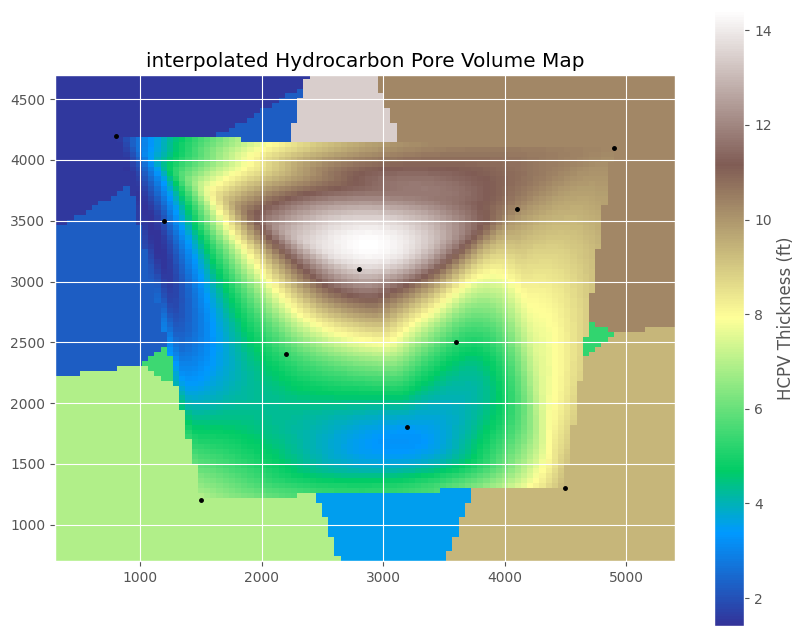

In [8]:
from scipy.interpolate import griddata

# Load dataset
df = pd.read_csv('data2.csv')

# Extract coordinates as a Numpy array
points = df[['X_Coordinate', 'Y_Coordinate']].values

# Compute Voronoi
vor = Voronoi(points)

# Define Field Boundary (Bounding Box)
# We add a small buffer around the min/max well locations
x_min, x_max = points[:,0].min() - 500, points[:,0].max() + 500
y_min, y_max = points[:,1].min() - 500, points[:,1].max() + 500

boundary_polygon = Polygon([
    (x_min, y_min), (x_max, y_min), 
    (x_max, y_max), (x_min, y_max)
])

# 1. Calculate Point-based HCPV Thickness at well locations
df['HCPV_Thick'] = df['Net_Pay'] * df['Porosity'] * (1 - df['Water_Saturation'])

# 2. Define a Meshgrid covering the field
grid_x, grid_y = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]

# 3. Interpolate (Cubic Spline)
# We interpolate HCPV thickness across the grid based on well data points
grid_hcpv = griddata(
    points, 
    df['HCPV_Thick'].values, 
    (grid_x, grid_y), 
    method='cubic',
    fill_value=np.nan # Use nearest or nan for outside hull
)

# Fill NaNs on edges (extrapolation issue) with nearest neighbor to avoid holes
mask = np.isnan(grid_hcpv)
grid_hcpv[mask] = griddata(
    points, 
    df['HCPV_Thick'].values, 
    (grid_x[mask], grid_y[mask]), 
    method='nearest'
)

# Visualize the Reservoir Quality Map
plt.figure(figsize=(10, 8))
plt.imshow(grid_hcpv.T, extent=(x_min, x_max, y_min, y_max), origin='lower', cmap='terrain')
plt.colorbar(label='HCPV Thickness (ft)')
plt.plot(points[:,0], points[:,1], 'k.', markersize=5)
plt.title('interpolated Hydrocarbon Pore Volume Map')
plt.show()

## 8. Zonal Statistics (Volumetric Integration)
Now we combine the **Voronoi Polygons** (Geometry) with the **Property Map** (Geology).

We will iterate through each well's Voronoi polygon and sum the interpolated HCPV values inside it. This gives us the **Original Oil In Place (OOIP)** for that specific drainage area.

**Volumetric Formula:**
$$OOIP_{bbl} = \frac{Area_{cell} \cdot \sum HCPV_{grid}}{5.615}$$
*(Note: 5.615 is the conversion factor from cubic feet to barrels)*

In [9]:
from matplotlib.path import Path

# --- PRE-CHECK: Ensure geometric area is calculated ---
# If you re-loaded the data, we need to re-calculate the polygon areas first
if 'Drainage_Area_Acres' not in df.columns:
    df['Drainage_Area_SqFt'] = [p.area for p in finite_polygons]
    df['Drainage_Area_Acres'] = df['Drainage_Area_SqFt'] / 43560

# --- MAIN: Zonal Statistics ---

# Create a flattened array of grid coordinates
grid_points = np.vstack([grid_x.ravel(), grid_y.ravel()]).T
hcpv_flat = grid_hcpv.ravel()

# Calculate area of a single grid cell (dx * dy)
dx = (x_max - x_min) / 100
dy = (y_max - y_min) / 100
cell_area_sqft = dx * dy

ooip_results = []

for i, poly in enumerate(finite_polygons):
    if poly is None or poly.is_empty:
        ooip_results.append(0)
        continue
        
    # Create a Path from the polygon vertices
    poly_path = Path(poly.exterior.coords)
    
    # Check which grid points are inside this polygon
    mask = poly_path.contains_points(grid_points)
    
    # Sum the HCPV thickness for points inside this well's polygon
    total_hcpv_thickness = np.sum(hcpv_flat[mask])
    
    # Calculate Volume: Sum(H * Cell_Area)
    reservoir_volume_cuft = total_hcpv_thickness * cell_area_sqft
    
    # Convert to Barrels (1 bbl = 5.615 cuft)
    ooip_bbl = reservoir_volume_cuft / 5.615
    ooip_results.append(ooip_bbl)

df['Calc_OOIP_BBL'] = ooip_results

# Now this line will work because we ensured the column exists
df[['Well_ID', 'Drainage_Area_Acres', 'Calc_OOIP_BBL']].head()

,Well_ID,Drainage_Area_Acres,Calc_OOIP_BBL
0,WELL-001,64.893811,3.138357e+06
1,WELL-002,42.671578,1.304647e+06
2,WELL-003,59.459201,3.902697e+06
3,WELL-004,57.939038,1.718227e+06
4,WELL-005,50.281522,4.618012e+06


## 9. Recovery Factor Analysis
Finally, we calculate the Recovery Factor (RF) to identify well performance.
$$RF = \frac{Cumulative Production}{OOIP}$$

* **Low RF:** Suggests the well is under-performing, or the drainage area contains barriers (faults/compartmentalization) not seen in the interpolation.
* **High RF (>50%):** Suggests the well is draining more than its theoretical Voronoi area (interference with neighbors).

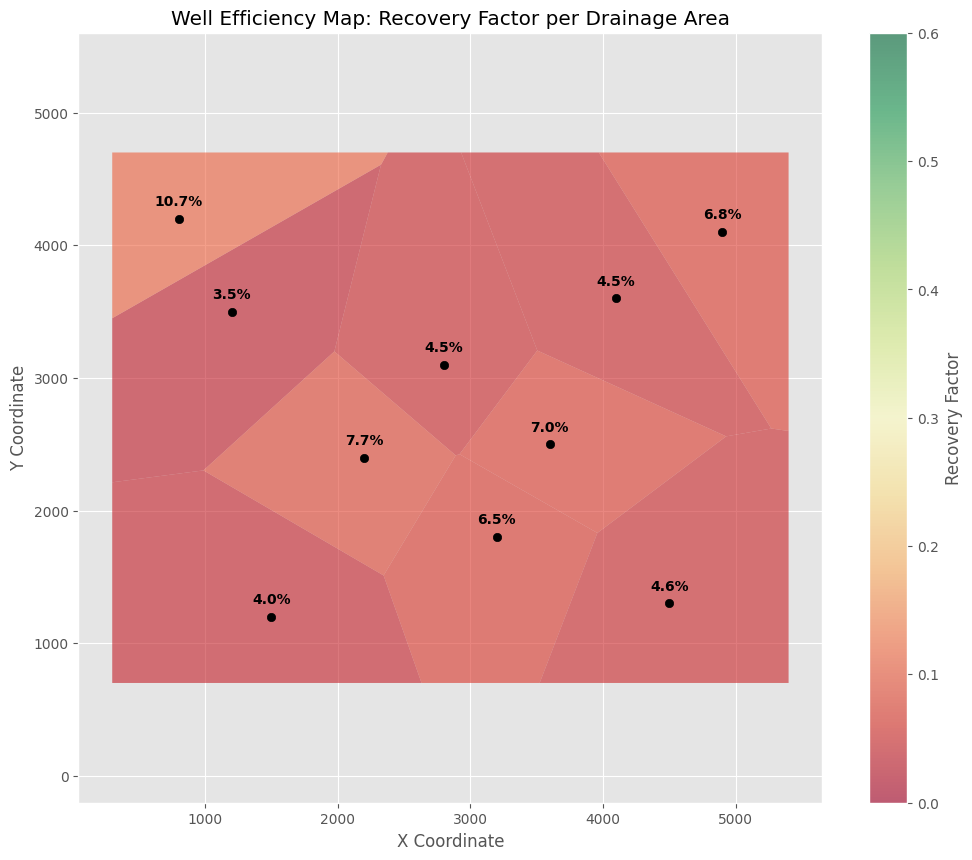

,Well_ID,Cum_Prod_BBL,Calc_OOIP_BBL,Recovery_Factor
3,WELL-004,60000,1.718227e+06,0.034920
0,WELL-001,125000,3.138357e+06,0.039830
5,WELL-006,190000,4.258857e+06,0.044613
4,WELL-005,210000,4.618012e+06,0.045474
2,WELL-003,180000,3.902697e+06,0.046122
1,WELL-002,85000,1.304647e+06,0.065152
9,WELL-010,195000,2.858385e+06,0.068220
7,WELL-008,115000,1.640914e+06,0.070083
6,WELL-007,110000,1.433117e+06,0.076756
8,WELL-009,45000,4.187137e+05,0.107472


In [10]:
df['Recovery_Factor'] = df['Cum_Prod_BBL'] / df['Calc_OOIP_BBL']

# Visualization: Recovery Factor Heatmap
fig, ax = plt.subplots(figsize=(12, 10))

# Plot Voronoi Polygons colored by Recovery Factor
patches = []
for poly in finite_polygons:
    if not poly.is_empty:
        x, y = poly.exterior.xy
        patches.append(MplPolygon(list(zip(x, y)), closed=True)) # Corrected closed=True

p = PatchCollection(patches, cmap='RdYlGn', alpha=0.6) # Red=Low RF, Green=High RF
p.set_array(df['Recovery_Factor'])
p.set_clim(0, 0.6) # Clamp colorbar between 0% and 60% RF
ax.add_collection(p)

# Overlay Wells
ax.scatter(points[:,0], points[:,1], c='black', zorder=5)

# Annotate with RF %
for i, row in df.iterrows():
    ax.annotate(f"{row['Recovery_Factor']:.1%}", 
                (row['X_Coordinate'], row['Y_Coordinate']+100), 
                fontsize=10, fontweight='bold', ha='center')

plt.colorbar(p, label='Recovery Factor')
plt.title('Well Efficiency Map: Recovery Factor per Drainage Area')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.axis('equal')
plt.show()

# Show tabular summary
df[['Well_ID', 'Cum_Prod_BBL', 'Calc_OOIP_BBL', 'Recovery_Factor']].sort_values('Recovery_Factor')

# 10. Detailed Analysis of Results

## A. Geometric vs. Geological "Ownership"
Comparing the **Voronoi Grid** with the **HCPV Map** reveals a critical discrepancy in reservoir management: **Area does not equal Volume.**

* **Geometric Bias:** Wells on the periphery (e.g., **WELL-001, WELL-003, WELL-004**) are assigned the largest drainage areas (>50 acres) purely due to the lack of neighboring competition.
* **Geological Reality:** The **HCPV Map** shows a distinct "sweet spot" (white/brown region) in the upper-central part of the field, characterized by high porosity and net pay.
* **The Conflict:** * **WELL-005** is located directly in the geological sweet spot but has a relatively small geometric drainage area due to crowding.
    * **WELL-001** has a massive geometric area but sits in a "blue" zone of poor reservoir quality (low thickness/porosity).
    
**Insight:** Relying solely on geometric spacing would overestimate the potential of edge wells (WELL-001) and underestimate the importance of central wells (WELL-005). The **Calculated OOIP** metrics in our dataframe correct this bias by integrating the rock quality.

## B. Recovery Factor & Efficiency Paradox
The **Recovery Factor (RF) Map** provides the most actionable insights regarding well performance.

1.  ** The "Large Area" Inefficiency**
    * Wells with the largest geometric areas often show the *lowest* recovery factors (e.g., **WELL-004 at 3.5%** and **WELL-006 at 4.5%**). 
    * **Interpretation:** It is physically unlikely for a single producer to effectively drain these massive, extended polygons. The low RF suggests that the "theoretical" oil in place assigned to these wells is not being fully contacted or produced. These areas are prime candidates for **Infill Drilling** to capture the stranded reserves.

2.  **The "Small Area" Efficiency**
    * **WELL-009** (Top Left) shows the highest Recovery Factor at **10.7%**. 
    * Despite being an edge well, its drainage area is moderate, and it likely sits in a compartment it drains effectively. High RF in a low-pay zone suggests this well is performing near its theoretical limit.

3.  **The Sweet Spot Opportunity**
    * **WELL-005** sits in the highest quality rock but shows a mediocre RF of **4.5%**.
    * **Interpretation:** This well has massive OOIP due to the thick pay zone, but current production hasn't kept pace. This indicates a potential **production bottleneck** (e.g., skin damage, low drawdown, or need for artificial lift upgrade).

## C. Field Development Recommendations

| Well Group | Observation | Recommendation |
| :--- | :--- | :--- |
| **Edge Wells (e.g., WELL-004, 003)** | Large Area, Low RF (<4%) | **Infill Drilling:** The current spacing is too wide; these wells cannot drain their assigned acres. Add a producer between WELL-004 and WELL-009. |
| **Sweet Spot Wells (e.g., WELL-005)** | High Pay, Moderate RF | **Stimulation / Workover:** The rock quality is excellent. Investigate why production is lagging behind the massive OOIP. |
| **High Performers (e.g., WELL-009)** | High RF (>10%) | **Maintain:** This well is efficient. Monitor for water breakthrough as it depletes its compartment faster than others. |

**Conclusion:**
Geometric Voronoi analysis serves as a good *base* for spacing, but integrating Geostatistical properties (HCPV) is essential for accurate reserve estimation. The discrepancy between "Ownership" (Area) and "Efficiency" (RF) highlights exactly where the next drilling or workover budget should be spent.